# Parallel Computing 1: iPyParallel
    Name

In [5]:
from ipyparallel import Client
import numpy as np
import time
from matplotlib import pyplot as plt
import random


In [6]:
% matplotlib inline

## Problem 1
Initializes a `Client` object, create a `DirectView` with all available engines, and import `scipy.sparse` as `sparse` on all engines.

(This is just to make sure your cluster is running and connected correctly)

In [7]:
# initialize client
client = Client()

# create directview
dview = client[:]
print(dview.targets)
# import scipy.sparse as sparse
dview.execute("import scipy.sparse as sparse")

[0, 1, 2, 3]


<AsyncResult: execute>

## Problem 2

Write a function `variables(dx)` that accepts a dictionary of variables.
Distribute the variables to all engines, then pull the variables back.

In [16]:
def variables(dx):
    """
    input: dictionary of variables
    
    tasks: push variables to all engines
           (from the problem 1 client)
           pull variables back and check them
               against the original dictionary
    """
    #if the given data type is a dictionary, push it then pull the values back
    if type(dx) == dict:
        dview.block = True
        dview.push(dx)
        print(dview.pull('j'))
    #if the variable given isnt a dicitonary, deny the variable
    else:
        raise ValueError("Expected a Dictionary")


In [18]:
# run something to check your function
#function only returns the dictionary key 'j''s value
#change the function to test what you want
test = {'a':10,'b':11,'j':"testing"}
variables(test)

['testing', 'testing', 'testing', 'testing']


## Problem 3

Write a function that accepts an integer n.
Instruct each engine to make n draws from the standard normal distribution, then hand back the minimum, maximum, and mean draw to the client.
Print the results.

In [44]:
def draw_statistics(n):
    """
    input: integer n
    
    tasks: each engine makes n draws from 
            standard normal distribution
           compute the min, max, and mean for
            each engine
           print the resulting lists of mins,
            maxs, and means
    """
    if type(n) == int:
        #imports the libraries needed
        dview.execute("import random")
        dview.execute("import numpy as np")
        #push the number given as n
        dview.push({'n':n})
        #use the n to make n draws from the standard normal
        dview.execute("draws = np.random.standard_normal(n)")
        #calculate the mean, max, and min for each n length draw
        dview.execute("means = np.mean(draws)")
        dview.execute("maxs=max(draws)")
        dview.execute("mins=min(draws)")
        #pull the mean, min and max and put them into an array to display
        means = dview.pull('means')
        maxs = dview.pull('maxs')
        mins = dview.pull('mins')
        #print the calculated values
        #print("means = " + str(means))
        #print("maxs = " + str(maxs))
        #print("mins = " + str(mins))
    else:
        raise TypeError("Expected an int")
        

In [41]:
# run something to check your function
draw_statistics(3)

means = [0.2881115039809953, -0.03386196895420341, 0.6747406842894913, 0.14460487086889584]
maxs = [0.7430589125770146, 0.40910865387348366, 0.9363265963189912, 2.4332506243998564]
mins = [-0.5699291825389777, -0.32289251411450937, 0.4220890035062702, -1.3630620653402457]


## Problem 4

Use `draw_statistics()` to compare serial and parallel execution times.
For $n = 1000000, 5000000, 10000000, 15000000,$
1. Time how long it takes to run your function.
2. Time how long it takes to do the same process (make n draws and calculate and record the statistics) in a for loop with $N$ iterations, where $N$ is the number of engines running.

Plot the execution times against $n$.
You should notice an increase in efficiency in the parallel
version as the problem size increases.

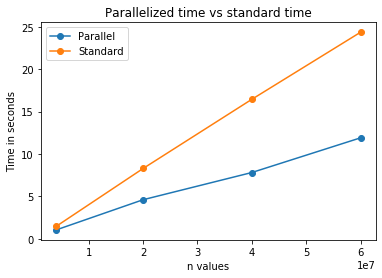

In [49]:
# make a list for both parellelized times and normal times
timesp = []
timess = []
#ns that will be used in each of the loops
N = [1000000,5000000,10000000,15000000]
for n in N:
    import time
    #get the initial time
    time1 = time.time()
    #draw stats n times from each core
    draw_statistics(n)
    time2 = time.time()
    total = time2-time1
    timesp.append(total)
for n in N:
    #get initial timing
    time1 = time.time()
    #from just one thing to 4 times the draws/mean/max/min calcs
    draws = np.random.standard_normal(4*n)
    mean = np.mean(draws)
    maxs = max(draws)
    mins = min(draws)
    time2 = time.time()
    timess.append(time2-time1)
#plot the times
plt.plot(np.array(N)*4,timesp,'-o',label="Parallel")
plt.plot(np.array(N)*4,timess,'-o',label="Standard")
plt.title("Parallelized time vs standard time")
plt.legend()
plt.xlabel("n values")
plt.ylabel("Time in seconds")
plt.show()
    



## Problem 5

Write a function that accepts a function handle $f$ to integrate, bounds of integration, and the number of points to use for the approximation.
Parallelize the trapezoid rule in order to estimate the integral of $f$ over the given bounds.
That is, evenly divide the points among all available processors and run the trapezoid rule on each portion simultaneously.
The sum of the results of all the processors will be the estimation of the integral over the entire interval of integration.
Return this sum.

Demonstrate that your function works.

In [8]:
def trapezoid_parallel(f, a, b, N):
    """
    inputs: f = func to integrate
            a,b = integration bounds
            N = number of points used
    tasks:  estimate integral of f
    """
    dview.execute("import numpy as np")
    domain,h = np.linspace(a,b,N,retstep=True)
    #make a function that will evaluate the step for the trapezoid method
    func = lambda a: (h/2)*(f(a)+f(a+h))
    #push the functions and stuff used in the func function
    dview.push({"domain":domain})
    dview.push({"f":f})
    dview.push({"h":h})
    #return the sum of the parts that are returned from the map
    return sum(dview.map(func,domain[:-1]))

In [9]:
# test f
f = lambda x: np.sin(x) + 4
a,b = 1,4
N = 40
#test the function to see that it works
print(trapezoid_parallel(f,a,b,N))
# evaluate integral using your function
# print'estimated integral:',trapezoid_parallel(f,a,b,N)

# compare to scipy result
# import scipy.integrate as integrate
# print'actual integral:',integrate.quad(f,a,b)[0]

13.193357137930239
